# Creating our Custom Algorithm with a sum of the left cumulative average and the right cumulative average

# 1. Left mean difference with right mean + 100 nt around peaks + 100nt chopped off + 100 nt buffer

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import ruptures as rpt
import pickle

In [2]:
# Function to read numbers from a file and return them as a list
def read_acc_from_file(file_path):
    acc = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip the newline character and convert the line to an integer
            accession = str(line.strip())
            acc.append(accession)
    return acc

# Example usage
file_path = '/mnt/Zika_total/acc.txt'  # Replace with the path to your file
acc_list = read_acc_from_file(file_path)
print(acc_list)

['ERR1802071', 'ERR1802073', 'ERR1802074', 'ERR1802079', 'SRR12615449', 'SRR12615452', 'SRR12615453', 'SRR12615466', 'SRR12615469', 'SRR12615470', 'SRR13084686', 'SRR13084689', 'SRR13084692', 'SRR13084695', 'SRR15923994', 'SRR15923995', 'SRR15923996', 'SRR21109253', 'SRR21109254', 'SRR21109257', 'SRR7660688', 'SRR7660689', 'SRR7660692', 'SRR7660693', 'SRR7660696', 'SRR7660698', 'SRR7660703', 'SRR7660704', 'SRR7660705', 'SRR7660718', 'SRR7660719', 'SRR7660720', 'SRR7660721', 'SRR7660722', 'SRR7660723', 'SRR7660724', 'SRR7660725', 'SRR7660726', 'SRR7660739', 'SRR7660740', 'SRR7660741', 'SRR7660742', 'SRR7660743', 'SRR7660744', 'SRR7660745', 'SRR7660746', 'SRR7660747', 'SRR8155998', 'SRR8155999', 'SRR8156000', 'SRR9106108', 'SRR9106110', 'SRR9106112', 'SRR9106114', 'SRR9106116', 'SRR9106118', 'SRR9106120', 'SRR9106122', 'SRR9106124', 'SRR9106126', 'SRR9106128', 'SRR9106130', 'SRR9106132', 'SRR9106134', 'SRR9106136', 'SRR9106138', 'SRR9106140', 'SRR9106142', 'SRR9106144', 'SRR9106146', 'SR

In [3]:
%cd /mnt/Zika_total/plotting/

/mnt/Zika_total/plotting


In [4]:
ground_truth = {"ERR1802071":False,"ERR1802073":True,"ERR1802074":True,"ERR1802079":False,"SRR12615449":True,"SRR12615452":True,"SRR12615453":True,"SRR12615466":True,"SRR12615469":True,"SRR12615470":True,"SRR13084686":False,"SRR13084689":False,"SRR13084692":False,"SRR13084695":False,"SRR15923994":True,"SRR15923995":False,"SRR15923996":False,"SRR21109253":False,"SRR21109254":False,"SRR21109257":False,"SRR7660688":True,"SRR7660689":True,"SRR7660692":True,"SRR7660693":True,"SRR7660696":True,"SRR7660698":True,"SRR7660703":False,"SRR7660704":False,"SRR7660705":True,"SRR7660718":False,"SRR7660719":False,"SRR7660720":False,"SRR7660721":False,"SRR7660722":False,"SRR7660723":False,"SRR7660724":False,"SRR7660725":False,"SRR7660726":False,"SRR7660739":False,"SRR7660740":False,"SRR7660741":False,"SRR7660742":False,"SRR7660743":False,"SRR7660744":True,"SRR7660745":True,"SRR7660746":True,"SRR7660747":False,"SRR8155998":False,"SRR8155999":False,"SRR8156000":False,"SRR9106108":False,"SRR9106110":False,"SRR9106112":False,"SRR9106114":False,"SRR9106116":False,"SRR9106118":False,"SRR9106120":True,"SRR9106122":True,"SRR9106124":True,"SRR9106126":False,"SRR9106128":False,"SRR9106130":True,"SRR9106132":False,"SRR9106134":False,"SRR9106136":True,"SRR9106138":False,"SRR9106140":True,"SRR9106142":False,"SRR9106144":False,"SRR9106146":False,"SRR9610797":True,"SRR9610798":True,"SRR9610799":True,"SRR9610800":True,"SRR9610801":True,"SRR9610805":True,"SRR9971533":False,"SRR9971534":False,"SRR9971537":False,"SRR9971538":False,"SRR9971539":False,"SRR9971540":False}

In [5]:
# chopped = 100
# buffer = 105
# detection_zone = 150
def classifier(chopped, buffer, detection_zone):
    TP=0
    TN=0
    FP=0
    FN=0
    for acc in acc_list:
        positive_start2 = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
        positive_start2 = positive_start2.sort_values(by=['Count'],ascending=False)
        top3peaks = positive_start2.head(3)
        top3peaks = top3peaks.to_numpy()
        
        
        #Read coverage Change Point Detection
        depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
        depth = depth.drop(columns=["Virus"])
        depth.set_index("Position", inplace=True)
        
        coverage = depth['Count'].values.reshape(-1,1)
    
        mean_diff = coverage.copy()   
        
        coverage = coverage[chopped:-chopped]    
    
        for i in range(chopped+buffer):
            mean_diff[i][0]=0
        for i in range(len(mean_diff)-(chopped+buffer),len(mean_diff)):
            mean_diff[i][0]=0
        # for i in mean_diff:
        #     print(i)
        
        for index in range(buffer,len(coverage)-buffer):
            left_mean = coverage[:index].mean()
            right_mean = coverage[index:].mean()
            diff = abs(right_mean - left_mean)
            # print(diff)
            mean_difference = diff
            mean_diff[index+chopped][0]=mean_difference
        
        result = mean_diff.argmax()
        # plt.plot(mean_diff)
        # plt.show()
        
        if (top3peaks[0][0] - detection_zone) <= result <= (top3peaks[0][0] + detection_zone) or \
            (top3peaks[1][0] - detection_zone) <= result <= (top3peaks[1][0] + detection_zone) or \
            (top3peaks[2][0] - detection_zone) <= result <= (top3peaks[2][0] + detection_zone):
            verdict = True
        else:
            verdict = False
    
        if ground_truth[acc] is True and verdict is True:
            TP +=1
        elif ground_truth[acc] is True and verdict is False:
            FN +=1
        elif ground_truth[acc] is False and verdict is True:
            FP +=1
        elif ground_truth[acc] is False and verdict is False:
            TN +=1

    try:
        precision = TP/(TP+FP)
    except ZeroDivisionError:
        precision = 0
    
    try:
        recall = TP/(TP+FN)
    except ZeroDivisionError:
        recall = 0
    
    try:
        f1_score = 2*(precision*recall)/(precision+recall)
    except ZeroDivisionError:
        f1_score = 0
    
    return precision, recall, f1_score

In [153]:
detection_zone = 150
chopped = 100
buffer = 150

precision, recall, f1_score = classifier(chopped, buffer, detection_zone)

print(precision)
print(recall)
print(f1_score)

print(TP,FN,TN,FP)

0.62
1.0
0.7654320987654321
31 0 31 20


In [6]:
algo_data = {'model':[], 'precision':[], 'recall': [], 'f1_score': []}
# model format: Classifier_$detection_zone_$chopped_$buffer

In [ ]:
for detection_zone in range (50,301,50):
    for chopped in range (40,191, 30):
        for buffer in range(50,301,25):
            precision, recall, f1_score = classifier(chopped, buffer, detection_zone)
            algo_data['model'].append(f"Classifier_{detection_zone}_{chopped}_{buffer}")
            algo_data['precision'].append(precision)
            algo_data['recall'].append(recall)
            algo_data['f1_score'].append(f1_score)

In [ ]:
with open('custom_classifier.pkl', 'wb') as f:
    pickle.dump(algo_data, f)

# Plotting the Pickled Data

In [5]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import pickle

In [6]:
%cd /mnt/Zika_total/

/mnt/Zika_total


In [7]:
with open('custom_classifier.pkl', 'rb') as f:
    algo_data = pickle.load(f)

In [9]:
algo_df = pd.DataFrame.from_dict(algo_data)

In [11]:
algo_df.set_index("model", inplace=True)

In [70]:
algo_df.to_csv('/mnt/Zika_total/plotting/metrics/algo_df_total.tsv', sep="\t", header=True, index=True)

In [38]:
precision_df = pd.DataFrame(algo_df['precision'])
recall_df = pd.DataFrame(algo_df['recall'])
f1_score_df = pd.DataFrame(algo_df['f1_score'])

precision_df = precision_df.sort_values(by=['precision'], ascending=False)
recall_df = recall_df.sort_values(by=['recall'], ascending=False)
f1_score_df = f1_score_df.sort_values(by=['f1_score'], ascending=False)

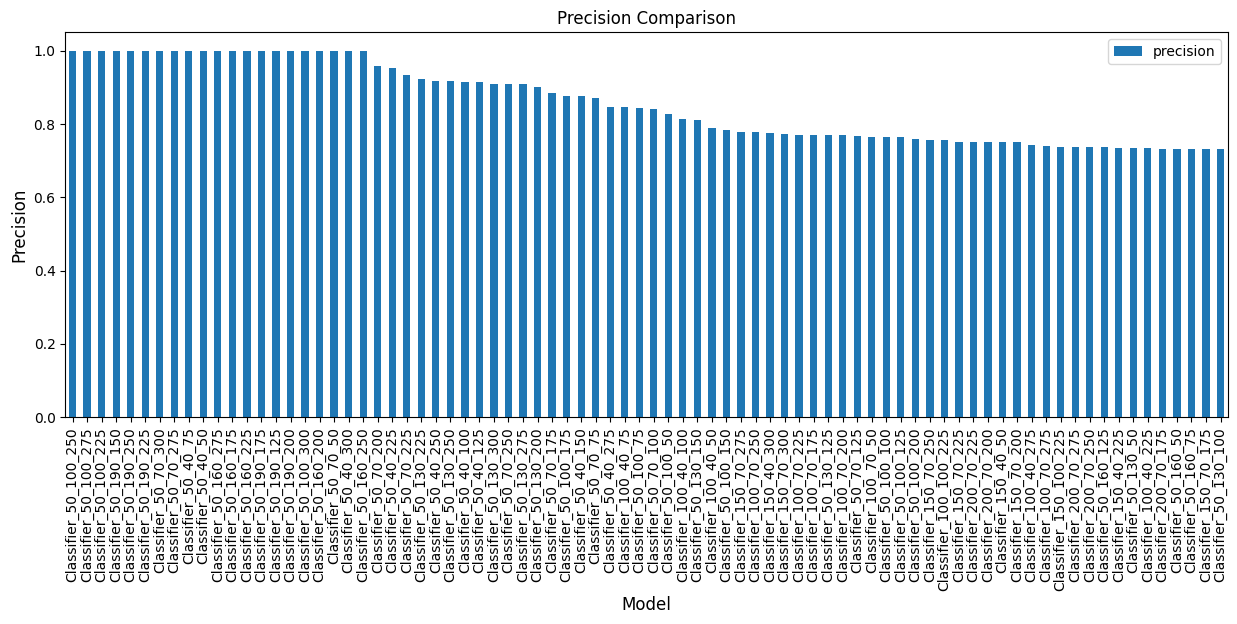

In [55]:
ax = precision_df[['precision']].head(80).plot(kind='bar', title ="Precision Comparison", figsize=(15, 5), legend=True, fontsize=10, rot=90)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
plt.show()

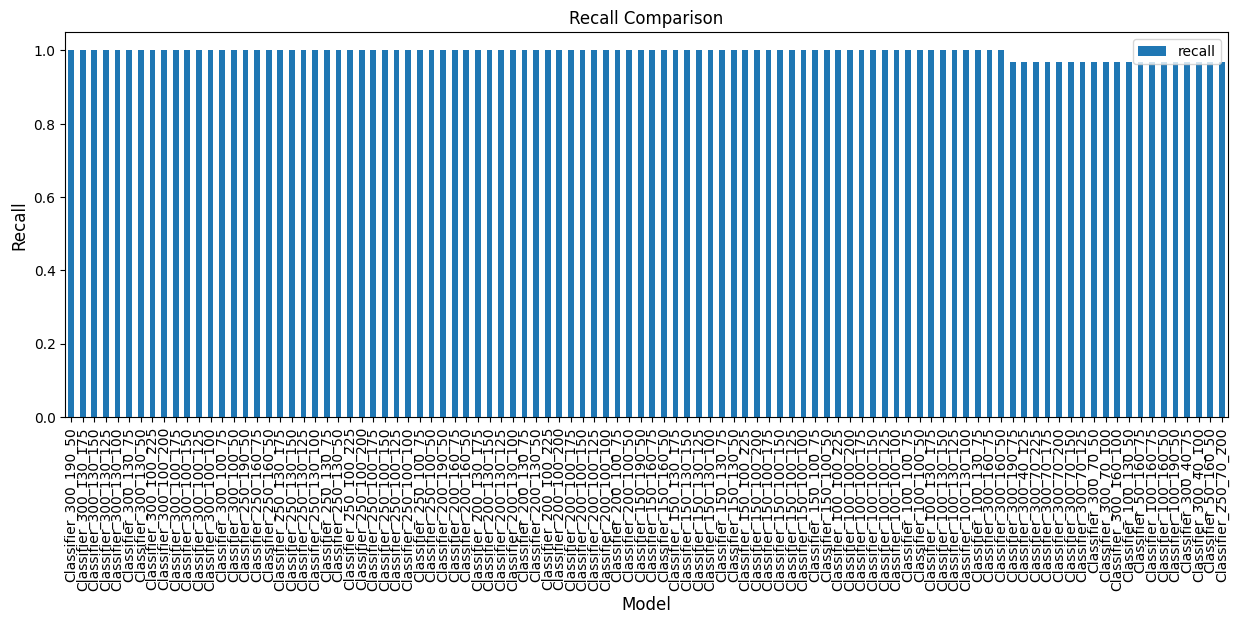

In [71]:
ax = recall_df[['recall']].head(100).plot(kind='bar', title ="Recall Comparison", figsize=(15, 5), legend=True, fontsize=10, rot=90)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Recall", fontsize=12)
plt.show()

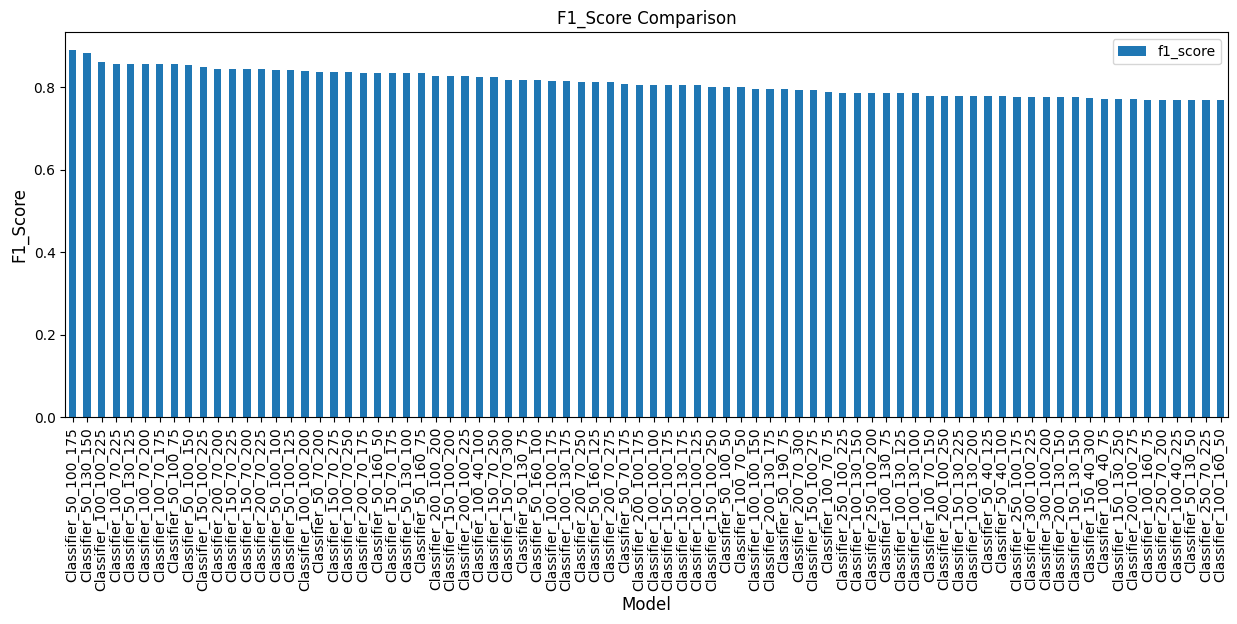

In [59]:
ax = f1_score_df[['f1_score']].head(80).plot(kind='bar', title ="F1_Score Comparison", figsize=(15, 5), legend=True, fontsize=10, rot=90)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("F1_Score", fontsize=12)
plt.show()

# Plotting

In [73]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import ruptures as rpt
import pickle

In [103]:
# Function to read numbers from a file and return them as a list
def read_acc_from_file(file_path):
    acc = []
    with open(file_path, 'r') as file:
        for line in file:
            # Strip the newline character and convert the line to an integer
            accession = str(line.strip())
            acc.append(accession)
    return acc

# Example usage
file_path = '/mnt/Zika_total/acc.txt'  # Replace with the path to your file
acc_list = read_acc_from_file(file_path)
print(acc_list)

['ERR1802071', 'ERR1802073', 'ERR1802074', 'ERR1802079', 'SRR12615449', 'SRR12615452', 'SRR12615453', 'SRR12615466', 'SRR12615469', 'SRR12615470', 'SRR13084686', 'SRR13084689', 'SRR13084692', 'SRR13084695', 'SRR15923994', 'SRR15923995', 'SRR15923996', 'SRR21109253', 'SRR21109254', 'SRR21109257', 'SRR7660688', 'SRR7660689', 'SRR7660692', 'SRR7660693', 'SRR7660696', 'SRR7660698', 'SRR7660703', 'SRR7660704', 'SRR7660705', 'SRR7660718', 'SRR7660719', 'SRR7660720', 'SRR7660721', 'SRR7660722', 'SRR7660723', 'SRR7660724', 'SRR7660725', 'SRR7660726', 'SRR7660739', 'SRR7660740', 'SRR7660741', 'SRR7660742', 'SRR7660743', 'SRR7660744', 'SRR7660745', 'SRR7660746', 'SRR7660747', 'SRR8155998', 'SRR8155999', 'SRR8156000', 'SRR9106108', 'SRR9106110', 'SRR9106112', 'SRR9106114', 'SRR9106116', 'SRR9106118', 'SRR9106120', 'SRR9106122', 'SRR9106124', 'SRR9106126', 'SRR9106128', 'SRR9106130', 'SRR9106132', 'SRR9106134', 'SRR9106136', 'SRR9106138', 'SRR9106140', 'SRR9106142', 'SRR9106144', 'SRR9106146', 'SR

In [72]:
%cd /mnt/Zika_total/plotting/

/mnt/Zika_total/plotting


In [75]:
reference_virus = {
"ERR1802071": "Zika_brazil","ERR1802073": "Zika_brazil","ERR1802074": "Zika_brazil","ERR1802079": "Zika_brazil","SRR12615449": "Zika_brazil","SRR12615452": "Zika_brazil","SRR12615453": "Zika_brazil","SRR12615466": "Zika_brazil","SRR12615469": "Zika_brazil","SRR12615470": "Zika_brazil","SRR13084686": "Zika_brazil","SRR13084689": "Zika_brazil","SRR13084692": "Zika_brazil","SRR13084695": "Zika_brazil","SRR21109253": "Zika_brazil","SRR21109254": "Zika_brazil","SRR21109257": "Zika_brazil","SRR7660688": "Zika_brazil","SRR7660689": "Zika_brazil","SRR7660692": "Zika_brazil","SRR7660693": "Zika_brazil","SRR7660696": "Zika_brazil","SRR7660698": "Zika_brazil","SRR7660703": "Zika_brazil","SRR7660704": "Zika_brazil","SRR7660705": "Zika_brazil","SRR7660718": "Zika_brazil","SRR7660719": "Zika_brazil","SRR7660720": "Zika_brazil","SRR7660721": "Zika_brazil","SRR7660722": "Zika_brazil","SRR7660723": "Zika_brazil","SRR7660724": "Zika_brazil","SRR7660725": "Zika_brazil","SRR7660726": "Zika_brazil","SRR7660739": "Zika_brazil","SRR7660740": "Zika_brazil","SRR7660741": "Zika_brazil","SRR7660742": "Zika_brazil","SRR7660743": "Zika_brazil","SRR7660744": "Zika_brazil","SRR7660745": "Zika_brazil","SRR7660746": "Zika_brazil","SRR7660747": "Zika_brazil","SRR8155998": "Zika_brazil","SRR8156000": "Zika_brazil","SRR9106108": "Zika_brazil","SRR9106110": "Zika_brazil","SRR9106112": "Zika_brazil","SRR9106114": "Zika_brazil","SRR9106116": "Zika_brazil","SRR9106118": "Zika_brazil","SRR9106120": "Zika_brazil","SRR9106122": "Zika_brazil","SRR9106124": "Zika_brazil","SRR9106126": "Zika_brazil","SRR9106128": "Zika_brazil","SRR9106130": "Zika_brazil","SRR9106132": "Zika_brazil","SRR9106134": "Zika_brazil","SRR9106136": "Zika_brazil","SRR9106138": "Zika_brazil","SRR9106140": "Zika_brazil","SRR9106142": "Zika_brazil","SRR9106144": "Zika_brazil","SRR9106146": "Zika_brazil","SRR9610797": "Zika_brazil","SRR9610798": "Zika_brazil","SRR9610799": "Zika_brazil","SRR9610800": "Zika_brazil","SRR9610801": "Zika_brazil","SRR9610805": "Zika_brazil","SRR9971529": "Zika_brazil","SRR9971530": "Zika_brazil","SRR9971531": "Zika_brazil","SRR9971532": "Zika_brazil","SRR9971533": "Zika_brazil","SRR9971534": "Zika_brazil","SRR9971535": "Zika_brazil","SRR9971536": "Zika_brazil","SRR9971537": "Zika_brazil","SRR9971538": "Zika_brazil","SRR9971539": "Zika_brazil","SRR9971540": "Zika_brazil","SRR15923994": "Zika_uganda","SRR15923995": "Zika_uganda","SRR15923996": "Zika_uganda","SRR8155999": "Zika_uganda"
}

In [79]:
# chopped = 100
# buffer = 105
# detection_zone = 150
def classifier_model(coverage, top3peaks, chopped, buffer, detection_zone):

    mean_diff = coverage.copy()   
    
    coverage = coverage[chopped:-chopped]    

    for i in range(chopped+buffer):
        mean_diff[i][0]=0
    for i in range(len(mean_diff)-(chopped+buffer),len(mean_diff)):
        mean_diff[i][0]=0
    # for i in mean_diff:
    #     print(i)
    
    for index in range(buffer,len(coverage)-buffer):
        left_mean = coverage[:index].mean()
        right_mean = coverage[index:].mean()
        diff = abs(right_mean - left_mean)
        # print(diff)
        mean_difference = diff
        mean_diff[index+chopped][0]=mean_difference
    
    result = mean_diff.argmax()
    # plt.plot(mean_diff)
    # plt.show()
        
    if (top3peaks[0][0] - detection_zone) <= result <= (top3peaks[0][0] + detection_zone) or \
        (top3peaks[1][0] - detection_zone) <= result <= (top3peaks[1][0] + detection_zone) or \
        (top3peaks[2][0] - detection_zone) <= result <= (top3peaks[2][0] + detection_zone):
        verdict = True
    else:
        verdict = False

    return result, verdict

In [104]:
chopped = 100
buffer = 225
detection_zone = 100

for acc in acc_list:
    
    original_depth = pd.read_csv("original_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    positive_depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    negative_depth = pd.read_csv("negative_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    positive_start = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    negative_start = pd.read_csv("negative_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    positive_end = pd.read_csv("positive_end/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    negative_end = pd.read_csv("negative_end/" + acc + ".tsv", sep="\t", names=["Position", "Count"])

    #5' start peak detection
    positive_start2 = pd.read_csv("positive_start/" + acc + ".tsv", sep="\t", names=["Position", "Count"])
    positive_start2 = positive_start2.sort_values(by=['Count'],ascending=False)
    top3peaks = positive_start2.head(3)
    top3peaks = top3peaks.to_numpy()


    #Read coverage Change Point Detection
    depth = pd.read_csv("positive_depth/" + acc + ".tsv", sep="\t", names=["Virus", "Position", "Count"])
    depth = depth.drop(columns=["Virus"])
    depth.set_index("Position", inplace=True)
    
    coverage = depth['Count'].values.reshape(-1,1)

    result, verdict = classifier_model(coverage, top3peaks, chopped, buffer, detection_zone)
    
    # Create a list of the dataframes for easy iteration
    dataframes = [original_depth, positive_depth, negative_depth, positive_start, negative_start, positive_end, negative_end]
    titles = [reference_virus[acc] + " Coverage", acc + " Sense Reads Coverage",acc + " Antisense Reads Coverage",
              acc + " Sense Read 5\' End",acc + " Antisense Read 3\' End", acc + " Sense Read 3\' End", acc + " Antisense Read 5\' End"]
    colours = ["magma",None, "autumn",None,"autumn",None, "autumn"]
    
    
    
    # Create subplots: 4 rows and 2 columns, but only using the first slot for a single graph
    fig = plt.figure()
    axs = []
    gs = gridspec.GridSpec(4, 2)
    axs.append(plt.subplot(gs[0, 0]))
    axs.append(plt.subplot(gs[1, 0]))
    axs.append(plt.subplot(gs[1, 1]))
    axs.append(plt.subplot(gs[2, 0]))
    axs.append(plt.subplot(gs[2, 1]))
    axs.append(plt.subplot(gs[3, 0]))
    axs.append(plt.subplot(gs[3, 1]))
    axs.append(plt.subplot(gs[0, 1]))
    
    # Plot each DataFrame on its corresponding subplot
    for i, df in enumerate(dataframes):
        ax = axs[i]
        if i==3:
            ax.plot(top3peaks[0][0],top3peaks[0][1], "ob")
            ax.plot(top3peaks[1][0],top3peaks[1][1], "ob")
            ax.plot(top3peaks[2][0],top3peaks[2][1], "ob")
            ax.legend(['Peaks'])
        if i==1:
            ax.vlines(result,ymin=0,ymax=df['Count'].max(), color='black', linestyles='dashed', linewidth = 4)

        if i==0 or i==1 or i==2:
            # predicted 5′ end of RNA “stem-loop 2” (SL2)
            ax.vlines(10478,ymin=0,ymax=df['Count'].max(), color='blue', linestyles='dashed', linewidth = 1)

            # predicted 5′ end of RNA “stem-loop 1” (SL1)
            ax.vlines(10394,ymin=0,ymax=df['Count'].max(), color='blue', linestyles='dashed', linewidth = 1)
            

            #position from Andrew's paper: https://www.biorxiv.org/content/10.1101/112904v1.full
            
        df.plot("Position", "Count", ax=ax, colormap=colours[i], figsize=(18, 18))
        ax.set_title(titles[i])

    
    axs[7].annotate("Prediction: " + str(verdict), (0.26,0.6), fontsize=35, bbox=dict(boxstyle="round", fc="0.8"))
    axs[7].annotate("sfRNA predicted start: " + str(result), (0.16,0.35), fontsize=30, bbox=dict(boxstyle="round", fc="0.8"))
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # plt.show()
    fig.savefig('/mnt/Zika_total/1final_plots/' + acc + '.png')
    plt.close(fig)

### Classifier_100_100_225

precision: 0.756097561

recall: 1

f1_score: 0.861111111